# 1. Load modules

In [41]:
%matplotlib widget 
#%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import colors
import matplotlib.ticker as ticker
from scipy import optimize
import xml.etree.ElementTree as ET

# 2. Set up the xrd-file path

In [42]:
filepath = "/local/MyGitHub/XRDmapAnalysis/xrd_files"
filename = "NT3334C_RSM_w2T-2T-105AlN-AlGaN_fast.xrdml"

# 3. Set default variables

In [43]:
AlN_Qx, AlN_Qy = 0.286985, 0.772766
GaN_Qx, GaN_Qy = 0.282129, 0.739455

AlN_a, AlN_c = 3.112, 4.982
GaN_a, GaN_c = 3.189, 5.185    
    
GaN_C13 = 106
GaN_C33 = 398
AlN_C13 = 108
AlN_C33 = 373

bowing_a = 0.1
bowing_c = 0.1
bowing_C13 = 0.1
bowing_C33 = 0.1



# 4. Read xrd-file

In [58]:
tree = ET.parse(f'{filepath}/{filename}')
root = tree.getroot()

In [59]:
print(f"Root element: {root.tag}")

Root element: {http://www.xrdml.com/XRDMeasurement/2.2}xrdMeasurements


In [156]:
# Parse the XML file
tree = ET.parse(f'{filepath}/{filename}')
root = tree.getroot()

# Print the root element
print(f"Root element: {root.tag}")

# declare XML namespaces
namespaces = {'ns': root.tag.split('}')[0].split('{')[1]}

Root element: {http://www.xrdml.com/XRDMeasurement/2.2}xrdMeasurements


In [157]:
namespaces

{'ns': 'http://www.xrdml.com/XRDMeasurement/2.2'}

In [ ]:
xrd(data_fname)

In [8]:
check_keyword_start = '\t\t\t\t<counts unit="counts">'
line_end_keyword = '</counts>\n'
count_list = [] # initialize: empty list
for line in data:
    if '<usedWavelength ' in line:
        used_wavelength = line.split('intended=')[1]      
    if check_keyword_start in line:
        my_string = line[len(check_keyword_start):-len(line_end_keyword)].split(" ")  
        count_list.append(my_string)
rsm_intesity = np.array(count_list, dtype=float)
lambda_wavelength = get_which_wavelen(used_wavelength)
print(f'Wavelenth used: {lambda_wavelength:.7f}')

Wavelenth used: 1.5405980


In [9]:
log_intensity = True
if log_intensity: 
    norm=colors.LogNorm() # logarithmic
else: 
    norm=colors.Normalize() # linear

Plotting real space map ...


Text(0, 0.5, '$\\omega$ / $2\\theta$')

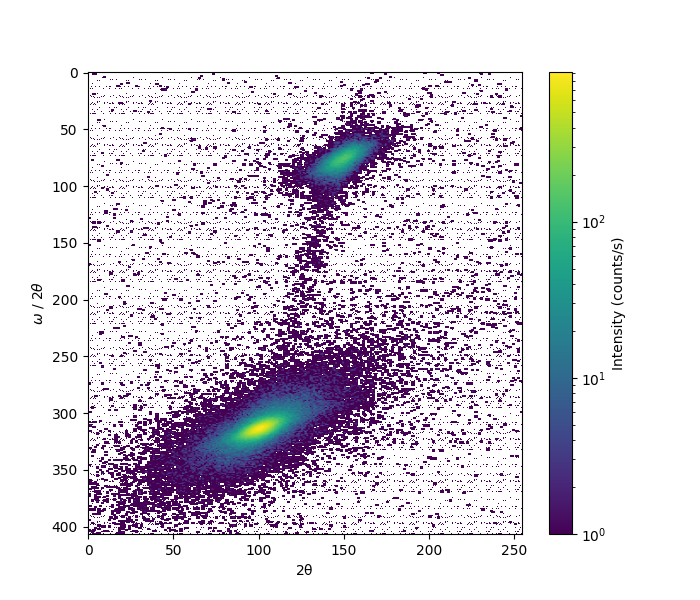

In [10]:
print('Plotting real space map ...')
xlabel_text = r'2$\mathrm{\theta}$'
ylabel_text = r'$\omega$ / $2\theta$'
fig, ax = plt.subplots(figsize=(7,6))
im = ax.imshow(rsm_intesity, norm=norm)
cbar = fig.colorbar(im, ax=ax, label='Intensity (counts/s)')
ax.set_aspect('auto')
ax.set_xlabel(xlabel_text)
ax.set_ylabel(ylabel_text)

In [11]:
row_n, col_n = np.shape(rsm_intesity)

In [12]:
startx_keyword = '<positions axis="2Theta" unit="deg">'
starty_keyword = '<positions axis="Omega" unit="deg">'

two_theta = [] # initialize: empty list
omega_list = []
for ii, line in enumerate(data):
    if startx_keyword in line:
        start_ = float(data[ii+1].split('startPosition>')[1].split('</')[0])
        end_ = float(data[ii+2].split('endPosition>')[1].split('</')[0])
        two_theta.append(np.linspace(start_, end_, num=col_n))
    if starty_keyword in line:
        omega_val = float(data[ii+1].split('commonPosition>')[1].split('</')[0])
        omega_list.append(np.array([omega_val]*col_n))

two_theta = np.array(two_theta)
omega_list = np.array(omega_list)

In [13]:
rsm_intesity[rsm_intesity<1e-5] = 1e-3

Plotting real space map ...


Text(0, 0.5, '$\\omega$ / $2\\theta$')

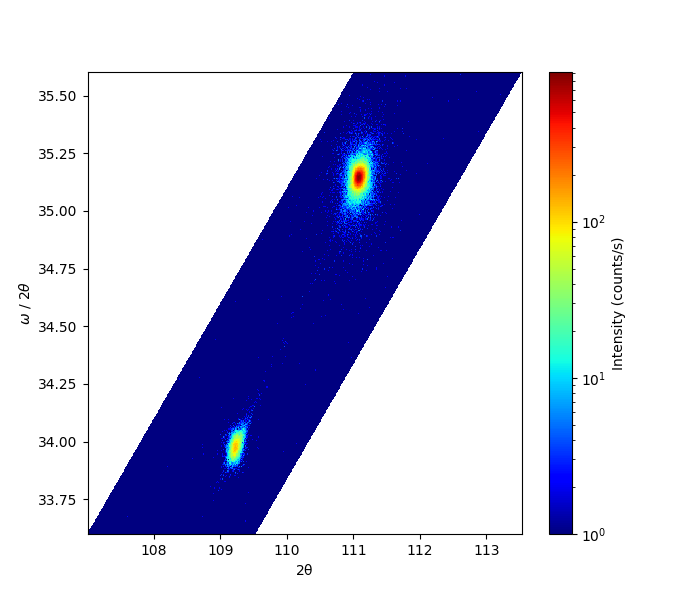

In [14]:
print('Plotting real space map ...')
xlabel_text = r'2$\mathrm{\theta}$'
ylabel_text = r'$\omega$ / $2\theta$'
fig, ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(two_theta, omega_list, rsm_intesity, shading='nearest', cmap="jet", norm=norm)
#im = ax.contourf(two_theta, omega_list,  rsm_intesity, norm=norm, levels=210, cmap='viridis')
cbar = fig.colorbar(im, ax=ax, label='Intensity (counts/s)')
ax.set_aspect('auto')
ax.set_xlabel(xlabel_text)
ax.set_ylabel(ylabel_text)

In [15]:
degree2radian=0.017453292519943295
def alloy_lattice_params(lattice_param_a, lattice_param_b, composition, bowing=0):
    return lattice_param_a*composition + lattice_param_b*(1-composition) + bowing*composition*(1-composition)

def Qxy_theor(a, c, mul_fact=10000, shift=[0,0]):
    qx, qy = 2/np.sqrt(3)/a*mul_fact + shift[0], 5/c*mul_fact + shift[1]
    return qx, qy

def omega_theor(a, c):
    return np.degrees((np.arcsin((lamb/2)*np.sqrt((1/(a**2))+(25/(c**2)))) - (c/a)*np.arccos(5/np.sqrt(26))))

def fmt(x, pos):
    a, b = '{:.2e}'.format(x).split('e')
    b = int(b)
    return r'${} \times 10^{{{}}}$'.format(a, b)

def Qy(omega, two_theta, R=1, mul_fact=10000):
    '''
    Q_y = R(sin(omega) + sin(2*theta-omega))
    degree2radian = pi/180
    '''
    return R * (np.sin(omega*degree2radian) + np.sin((two_theta - omega)*degree2radian)) * mul_fact

def Qx(omega, two_theta, R=1, mul_fact=10000):
    '''
    Q_x = R(cos(omega) - cos(2*theta-omega))
    degree2radian = pi/180
    '''
    return R * (np.cos(omega*degree2radian) - np.cos((two_theta - omega)*degree2radian)) * mul_fact

def c_strained(a, a0, c0, C13, C33):
    return c0*(1-2*(C13/C33)*((a-a0)/(a0)))

In [16]:
test = np.zeros(16)
i=0
while(i<10):
    test[i] = i*80
    i=i+1
    
test[10] = 1e3
test[11] = 2e3
test[12] = 3e3
test[13] = 5e3
test[14] = 8e3
test[15] = 1e4

In [17]:
# axis conversion
mul_fact = 10000
# X-ray wave number
R = 1/lambda_wavelength

In [19]:
Qxy_theor_AlN = Qxy_theor(AlN_a, AlN_c) 
Qxy_theor_GaN = Qxy_theor(GaN_a, GaN_c) 
Qx_theory_AlN_GaN = [Qxy_theor_AlN[0],Qxy_theor_GaN[0]]
Qy_theory_AlN_GaN = [Qxy_theor_AlN[1],Qxy_theor_GaN[1]]

In [20]:
##============================================
xlabel_text = f'Qx*{mul_fact} (rlu)'
ylabel_text = f'Qy*{mul_fact} (rlu)'

rec_space_x = Qx(omega_list, two_theta, R=R, mul_fact=mul_fact)
rec_space_y = Qy(omega_list, two_theta, R=R, mul_fact=mul_fact)

##============================================
# TBD: make a fitting function to get the maximum positions
max_intensity_pos = np.unravel_index(np.argmax(rsm_intesity, axis=None), rsm_intesity.shape)
x_coord_max = rec_space_x[max_intensity_pos]
y_coord_max = rec_space_y[max_intensity_pos]
#print(f'{x_coord_max}, {y_coord_max}')

##============================================
shift_xy_ = [x_coord_max-Qxy_theor_AlN[0], y_coord_max-Qxy_theor_AlN[1]]
Qxy_theor_shift_AlN = Qxy_theor(AlN_a, AlN_c, shift=shift_xy_) 
Qxy_theor_shift_GaN = Qxy_theor(GaN_a, GaN_c, shift=shift_xy_) 
Qx_theory_shift_AlN_GaN = [Qxy_theor_shift_AlN[0],Qxy_theor_shift_GaN[0]]
Qy_theory_shift_AlN_GaN = [Qxy_theor_shift_AlN[1],Qxy_theor_shift_GaN[1]]

In [21]:
in_betwwen_compositions = np.linspace(Qxy_theor_shift_AlN, Qxy_theor_shift_GaN, num=4)

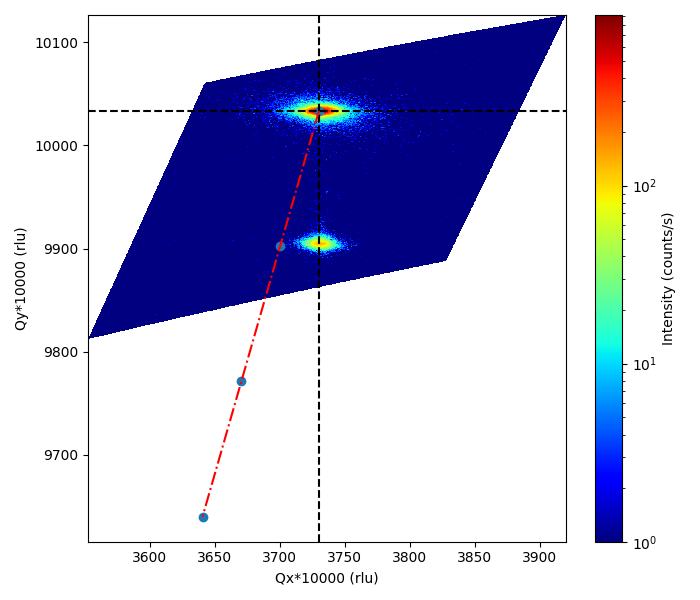

In [22]:
# =============== plotting ===================
fig, ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(rec_space_x, rec_space_y, rsm_intesity, shading='nearest', cmap="jet", norm=norm)
#cp = plt.contour(rec_space_x, rec_space_y, rsm_intesity, colors='black', linewidths=1, levels=test)
ax.set_aspect('auto')
ax.set_xlabel(xlabel_text)
ax.set_ylabel(ylabel_text)
fig.colorbar(im, ax=ax, label='Intensity (counts/s)')
ax.axhline(y=y_coord_max, ls='--', color='black')
ax.axvline(x=x_coord_max, ls='--', color='black')
ax.plot(Qx_theory_shift_AlN_GaN, Qy_theory_shift_AlN_GaN, color='r', ls='-.')
#ax.plot(Qx_theory_AlN_GaN, Qy_theory_AlN_GaN, color='k', ls='-.')
ax.scatter(in_betwwen_compositions[:,0], in_betwwen_compositions[:,1], marker='o')
plt.tight_layout()

In [24]:
def get_extrapolation(x, a_bin, b_bin, bowing:float=0):
    return a_bin * x + b_bin * (1.0 - x) + bowing * x * (1-x)

In [46]:
comps_ = np.linspace(0,1,11) #np.arange(0, 1.0+1e-10, step=0.25) 
AlGaN_a = get_extrapolation(comps_, AlN_a, GaN_a, bowing=bowing_a) 
AlGaN_c = get_extrapolation(comps_, AlN_c, GaN_c, bowing=bowing_c) 
AlGaN_C13 = get_extrapolation(comps_, AlN_C13, GaN_C13, bowing=bowing_C13) 
AlGaN_C33 = get_extrapolation(comps_, AlN_C33, GaN_C33, bowing=bowing_C33) 
AlGaN_D = -2*(AlGaN_C13/AlGaN_C33)

In [47]:
comps_

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [48]:
Qxy_theor_AlGaN = Qxy_theor(AlGaN_a, AlGaN_c) 
Qxy_theor_shift_AlGaN = Qxy_theor(AlGaN_a, AlGaN_c, shift=shift_xy_) 
Qxy_theor_shift_AlGaN_y_prime = Qxy_theor_shift_AlGaN[1] - AlGaN_D*(Qxy_theor_shift_AlGaN[0]-x_coord_max)

# Plotting

In [49]:
#Show the original theoretical line
show_org_theory = False 

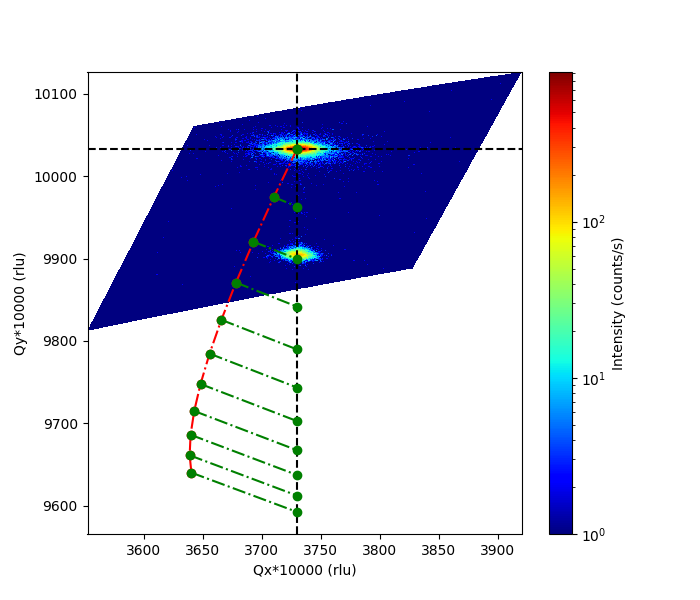

In [50]:
fig, ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(rec_space_x, rec_space_y, rsm_intesity, shading='nearest', cmap="jet", norm=norm)
#cp = plt.contour(rec_space_x, rec_space_y, rsm_intesity, colors='black', linewidths=1, levels=test)
ax.set_aspect('auto')
ax.set_xlabel(xlabel_text)
ax.set_ylabel(ylabel_text)
fig.colorbar(im, ax=ax, label='Intensity (counts/s)')
ax.axhline(y=y_coord_max, ls='--', color='black')
ax.axvline(x=x_coord_max, ls='--', color='black')
ax.plot(Qxy_theor_shift_AlGaN[0], Qxy_theor_shift_AlGaN[1], color='r', ls='-.', marker='o')
if show_org_theory: ax.plot(Qxy_theor_AlGaN[0], Qxy_theor_AlGaN[1], color='k', ls='-.', marker='o')
for JJ in range(len(comps_)):
    ax.plot([Qxy_theor_shift_AlGaN[0][JJ], x_coord_max],
            [Qxy_theor_shift_AlGaN[1][JJ], Qxy_theor_shift_AlGaN_y_prime[JJ]], 
            color='g', ls='-.', marker='o')
#plt.tight_layout()

In [51]:
reverse_compostion_point = [3698, 9713] 
a2 = (reverse_compostion_point[1] - y_coord_max)/(reverse_compostion_point[0] - x_coord_max)
b2 = -1
c2 = (y_coord_max*reverse_compostion_point[0] - x_coord_max*reverse_compostion_point[1])/(reverse_compostion_point[0]-x_coord_max)
a1 = AlGaN_D
b1 = -1
c1 = Qxy_theor_shift_AlGaN[1] - AlGaN_D*Qxy_theor_shift_AlGaN[0]

xx = (b1*c2 - b2*c1)/(a1*b2 - a2*b1) 
yy = (a2*c1 - a1*c2)/(a1*b2 - a2*b1)

In [52]:
all_dist = np.array([np.linalg.norm(np.array(reverse_compostion_point)-np.array(b)) for b in zip(xx, yy)])
closest_points_pos = np.argsort(all_dist)[:2]
closest_points = all_dist[closest_points_pos]
closest_points_D = AlGaN_D[closest_points_pos]

best_D = np.average(AlGaN_D[closest_points_pos], weights=closest_points)

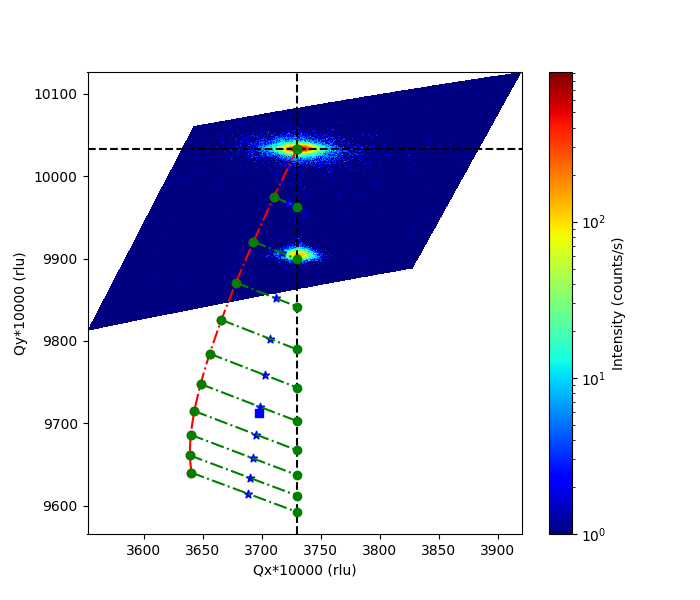

In [53]:
fig, ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(rec_space_x, rec_space_y, rsm_intesity, shading='nearest', cmap="jet", norm=norm)
#cp = plt.contour(rec_space_x, rec_space_y, rsm_intesity, colors='black', linewidths=1, levels=test)
ax.set_aspect('auto')
ax.set_xlabel(xlabel_text)
ax.set_ylabel(ylabel_text)
fig.colorbar(im, ax=ax, label='Intensity (counts/s)')
ax.axhline(y=y_coord_max, ls='--', color='black')
ax.axvline(x=x_coord_max, ls='--', color='black')
ax.plot(Qxy_theor_shift_AlGaN[0], Qxy_theor_shift_AlGaN[1], color='r', ls='-.', marker='o')
if show_org_theory: ax.plot(Qxy_theor_AlGaN[0], Qxy_theor_AlGaN[1], color='k', ls='-.', marker='o')
for JJ in range(len(comps_)):
    ax.plot([Qxy_theor_shift_AlGaN[0][JJ], x_coord_max],
            [Qxy_theor_shift_AlGaN[1][JJ], Qxy_theor_shift_AlGaN_y_prime[JJ]], 
            color='g', ls='-.', marker='o')

ax.scatter(reverse_compostion_point[0], reverse_compostion_point[1], marker='s', color='b')
ax.scatter(xx, yy, marker='*', color='b')
#plt.tight_layout()

In [54]:
print(AlN_a, AlN_c)
print(2/np.sqrt(3)/AlN_a*10000, 5/AlN_c*10000) # correct
print(1/AlN_a*10000, 5/AlN_c*10000) # wrong

3.112 4.982
3710.477308416618 10036.130068245684
3213.367609254499 10036.130068245684


In [55]:
aln_lp = 23
cal_strain = 2-aln_lp/aln_lp
print(cal_strain)

1.0


## My Test: Badal

In [56]:
Qxy_theor_AlGaN = Qxy_theor(AlGaN_a, AlGaN_c) 
Qxy_theor_shift_AlGaN = Qxy_theor(AlGaN_a, AlGaN_c, shift=shift_xy_) 
Qxy_theor_shift_AlGaN_y_prime = Qxy_theor_shift_AlGaN[1] - AlGaN_D*(Qxy_theor_shift_AlGaN[0]-x_coord_max)

In [57]:
t = np.linspace(0,1,11)
AlGaN_a = get_extrapolation(t, AlN_a, GaN_a, bowing=bowing_a) 
AlGaN_c = get_extrapolation(t, AlN_c, GaN_c, bowing=bowing_c) 
AlGaN_C13 = get_extrapolation(t, AlN_C13, GaN_C13, bowing=bowing_C13) 
AlGaN_C33 = get_extrapolation(t, AlN_C33, GaN_C33, bowing=bowing_C33) 
AlGaN_D = -2*(AlGaN_C13/AlGaN_C33)

Qxy_theor_AlGaN = Qxy_theor(AlGaN_a, AlGaN_c, shift=shift_xy_) 
Qxy_theor_AlN = Qxy_theor(AlN_a, AlN_c, shift=shift_xy_)

In [58]:
XX = Qxy_theor_AlGaN[0].copy()
tmp_ = Qxy_theor_AlGaN[1] - AlGaN_D*Qxy_theor_AlGaN[0]
c_Qy = AlGaN_D[:, None] * XX + tmp_[:, None]

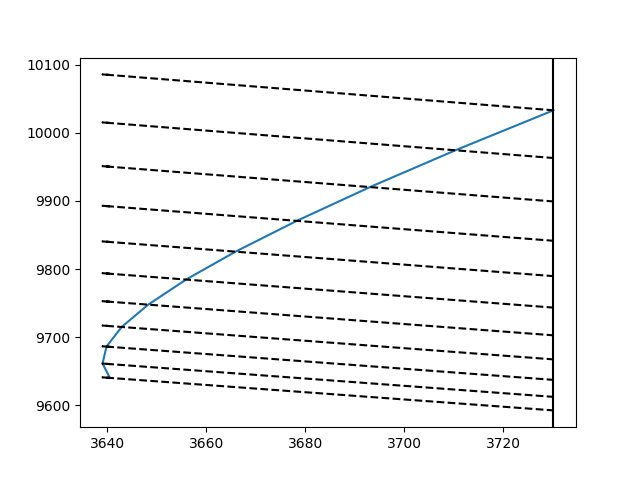

In [59]:
plt.figure()
plt.plot(Qxy_theor_AlGaN[0], Qxy_theor_AlGaN[1])
plt.axvline(x=Qxy_theor_AlN[0], c='k', ls='-')
for JJ in range(len(c_Qy)):
    plt.plot(XX, c_Qy[JJ], 'k--')
    #break

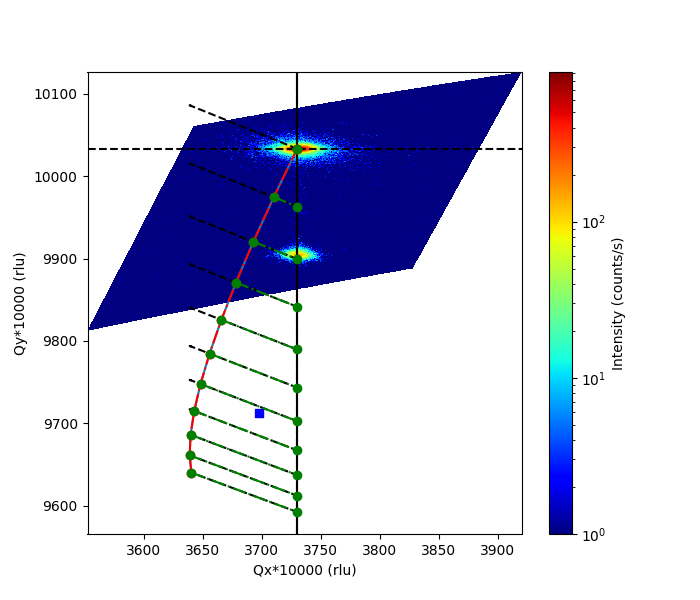

In [60]:
fig, ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(rec_space_x, rec_space_y, rsm_intesity, shading='nearest', cmap="jet", norm=norm)
#cp = plt.contour(rec_space_x, rec_space_y, rsm_intesity, colors='black', linewidths=1, levels=test)
ax.set_aspect('auto')
ax.set_xlabel(xlabel_text)
ax.set_ylabel(ylabel_text)
fig.colorbar(im, ax=ax, label='Intensity (counts/s)')
ax.axhline(y=y_coord_max, ls='--', color='black')
ax.axvline(x=x_coord_max, ls='--', color='black')
plt.plot(Qxy_theor_AlGaN[0], Qxy_theor_AlGaN[1])
plt.axvline(x=Qxy_theor_AlN[0], c='k', ls='-')
for JJ in range(len(c_Qy)):
    plt.plot(XX, c_Qy[JJ], 'k--')
ax.plot(Qxy_theor_shift_AlGaN[0], Qxy_theor_shift_AlGaN[1], color='r', ls='-.', marker='o')
if show_org_theory: ax.plot(Qxy_theor_AlGaN[0], Qxy_theor_AlGaN[1], color='k', ls='-.', marker='o')
for JJ in range(len(comps_)):
    ax.plot([Qxy_theor_shift_AlGaN[0][JJ], x_coord_max],
            [Qxy_theor_shift_AlGaN[1][JJ], Qxy_theor_shift_AlGaN_y_prime[JJ]], 
            color='g', ls='-.', marker='o')

ax.scatter(reverse_compostion_point[0], reverse_compostion_point[1], marker='s', color='b')
# ax.scatter(xx, yy, marker='*', color='b')

In [61]:

def find_zero_function(t, qx, qy, 
                       AlN_a, GaN_a, bowing_a, 
                       AlN_c, GaN_c, bowing_c,
                       AlN_C13, GaN_C13, bowing_C13, 
                       AlN_C33, GaN_C33, bowing_C33, shift):
    AlGaN_a = AlN_a * t + GaN_a * (1.0 - t) + bowing_a * t * (1-t) 
    AlGaN_c = AlN_c * t + GaN_c * (1.0 - t) + bowing_c * t * (1-t)  
    AlGaN_C13 = AlN_C13 * t + GaN_C13 * (1.0 - t) + bowing_C13 * t * (1-t) #get_extrapolation(t, AlN_C13, GaN_C13) 
    AlGaN_C33 = AlN_C33 * t + GaN_C33 * (1.0 - t) + bowing_C33 * t * (1-t) #get_extrapolation(t, AlN_C33, GaN_C33) 
    AlGaN_D = -2*(AlGaN_C13/AlGaN_C33)
    Qx_, Qy_ = 2/np.sqrt(3)/AlGaN_a*mul_fact + shift[0], 5/AlGaN_c*mul_fact + shift[1]
    return AlGaN_D*qx - qy + Qy_ -  AlGaN_D*Qx_

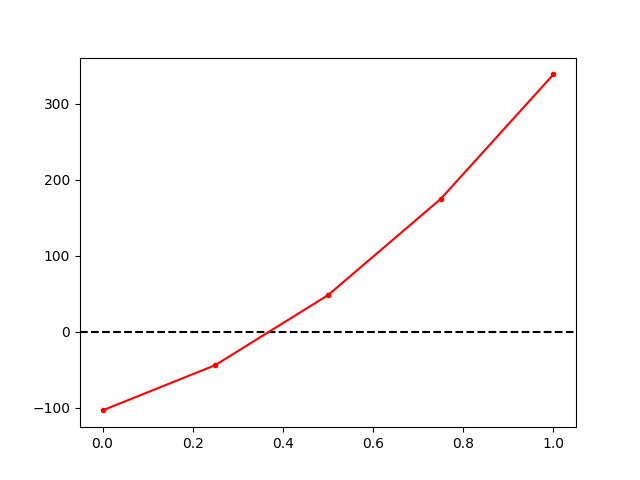

In [62]:
t = np.linspace(0,1,5)
f_args = (reverse_compostion_point[0], reverse_compostion_point[1], 
          AlN_a, GaN_a, bowing_a, AlN_c, GaN_c, bowing_c,
          AlN_C13, GaN_C13, bowing_C13, AlN_C33, GaN_C33, bowing_C33, shift_xy_)
plt.figure()
plt.axhline(y=0, ls='--',c='k')
plt.plot(t, find_zero_function(t, *f_args), c='r', marker='.')

In [63]:
sol = optimize.root_scalar(find_zero_function, args=f_args, bracket=[0, 1], method='brentq')
assert sol.converged, 'Root finding not converged. try other methods.'
print(f'Composition: {sol.root: .3f}')

Composition:  0.380
